# Medical Appointment No-Shows: Advanced Prediction with Automated Feature Engineering and Class Imbalance Handling

## Project Structure
This notebook is organized as follows:

1. **Setup and Imports**: Installing and importing necessary libraries
2. **Data Acquisition**: Loading multiple datasets for testing
3. **Data Preprocessing**: Cleaning and preparing data for analysis
4. **Feature Engineering**:
   - Manual feature engineering based on domain knowledge
   - Automated feature engineering using featuretools
5. **Exploratory Data Analysis**: Understanding patterns in the data
6. **Model Building and Evaluation**:
   - Baseline model (without handling class imbalance)
   - Our approach (automated features + SMOTE)
7. **Results Comparison**: Comparing our approach to the baseline across datasets
8. **Conclusions and Recommendations**: Insights and practical applications

## Project Goal
This project aims to improve the prediction of appointment no-shows by:
1. Automating the feature engineering process to discover non-obvious predictors
2. Effectively handling class imbalance to improve minority class detection
3. Creating a generalizable approach that works across multiple domains

The effectiveness of our approach is demonstrated on four different datasets with varying characteristics and imbalance ratios.

In [3]:
# Install required packages
!pip install scikit-learn==1.3.2 --upgrade -q
!pip install xgboost --upgrade -q
!pip install featuretools --upgrade -q
!pip install imbalanced-learn --upgrade -q
!pip install kagglehub --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 18.3 MB/s eta 0:00:00


In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import featuretools as ft
import os
import re
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, balanced_accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import warnings

# Set visualization style
sns.set(style="whitegrid")
plt.style.use('fivethirtyeight')

# For reproducibility
np.random.seed(42)
warnings.filterwarnings('ignore')

In [17]:
# 1. Data Acquisition and Exploration

# Define a function to load and preprocess datasets
def load_dataset(dataset_name):
    """
    Load and preprocess a dataset for testing our approach

    Parameters:
    dataset_name (str): Name of the dataset to load

    Returns:
    DataFrame: Preprocessed dataset
    """
    if dataset_name == "medical_appointments":
        # Original medical appointments dataset
        try:
            import kagglehub
            path = kagglehub.dataset_download("joniarroba/noshowappointments")
            data_path = os.path.join(path, 'KaggleV2-May-2016.csv')
            df = pd.read_csv(data_path)

            # Basic preprocessing
            df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
            df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
            df['NoShow'] = df['No-show'].map({'Yes': 1, 'No': 0})
            df = df.drop(['No-show'], axis=1)

            # Create some basic features
            df['WaitDays'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
            df['DayOfWeek'] = df['AppointmentDay'].dt.day_name()
            df['IsWeekend'] = df['AppointmentDay'].dt.dayofweek >= 5

            # Take a sample to make processing faster
            df = df.sample(n=min(20000, len(df)), random_state=42)

            return df
        except Exception as e:
            print(f"Error loading medical_appointments: {e}")
            # Fallback to breast cancer dataset if kaggle dataset fails
            from sklearn.datasets import load_breast_cancer
            data = load_breast_cancer()
            df = pd.DataFrame(data.data, columns=data.feature_names)
            df['target'] = data.target
            df['NoShow'] = 1 - df['target']  # Convert to match our target (1=positive class)
            df = df.drop(['target'], axis=1)
            return df

    elif dataset_name == "breast_cancer":
        # UCI Breast Cancer dataset (binary classification)
        from sklearn.datasets import load_breast_cancer
        data = load_breast_cancer()
        df = pd.DataFrame(data.data, columns=data.feature_names)
        df['target'] = data.target
        df['NoShow'] = 1 - df['target']  # Convert to match our target (1=positive class)
        df = df.drop(['target'], axis=1)

        return df

    elif dataset_name == "diabetes":
        # Pima Indians Diabetes dataset
        url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
        column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                        'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
        df = pd.read_csv(url, names=column_names)
        df['NoShow'] = df['Outcome']  # Rename to match our target
        df = df.drop(['Outcome'], axis=1)

        return df

    elif dataset_name == "credit_card_fraud":
        # Credit Card Fraud Detection dataset (highly imbalanced)
        # Note: This is a large dataset, so we'll use a sample
        try:
            # Try to load from a public URL
            url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
            df = pd.read_csv(url)
            df['NoShow'] = df['Class']  # Rename to match our target
            df = df.drop(['Class'], axis=1)

            # Take a sample to make it manageable
            fraud = df[df['NoShow'] == 1]
            non_fraud = df[df['NoShow'] == 0].sample(n=min(len(fraud)*10, 5000), random_state=42)
            df = pd.concat([fraud, non_fraud])

            return df
        except:
            # Fallback to a synthetic dataset if the URL fails
            from sklearn.datasets import make_classification
            X, y = make_classification(n_samples=1000, n_features=20, n_informative=2,
                                      n_redundant=10, n_classes=2, weights=[0.9, 0.1],
                                      random_state=42)
            df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
            df['NoShow'] = y
            return df

    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

# List of datasets to test
datasets = ["medical_appointments", "breast_cancer", "diabetes", "credit_card_fraud"]

# Load the first dataset for initial exploration
current_dataset = datasets[0]
df = load_dataset(current_dataset)

print(f"Loaded dataset: {current_dataset}")
print(f"Dataset shape: {df.shape}")
print(f"Class distribution: {df['NoShow'].value_counts(normalize=True)}")
df.head()

Loaded dataset: medical_appointments
Dataset shape: (20000, 17)
Class distribution: NoShow
0    0.7991
1    0.2009
Name: proportion, dtype: float64


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,NoShow,WaitDays,DayOfWeek,IsWeekend
84674,2.759575e+13,5756417,F,2016-06-01 08:17:04+00:00,2016-06-01 00:00:00+00:00,20,ILHA DAS CAIEIRAS,0,0,0,0,0,0,0,-1,Wednesday,False
3635,9.673194e+14,5523159,F,2016-03-29 16:09:39+00:00,2016-05-03 00:00:00+00:00,37,RESISTÊNCIA,0,0,0,0,0,1,0,34,Tuesday,False
16605,3.951641e+12,5693080,F,2016-05-12 17:33:56+00:00,2016-05-20 00:00:00+00:00,38,MARIA ORTIZ,0,0,0,0,0,0,1,7,Friday,False
103942,9.173245e+14,5654129,F,2016-05-03 13:54:51+00:00,2016-06-03 00:00:00+00:00,24,SANTO ANDRÉ,0,0,0,0,0,1,1,30,Friday,False
274,3.995366e+12,5641070,F,2016-04-29 12:16:28+00:00,2016-04-29 00:00:00+00:00,41,MARIA ORTIZ,0,0,0,0,0,0,0,-1,Friday,False


In [18]:
# Check data types and missing values
df.info()

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Summary statistics
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 84674 to 71671
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   PatientId       20000 non-null  float64            
 1   AppointmentID   20000 non-null  int64              
 2   Gender          20000 non-null  object             
 3   ScheduledDay    20000 non-null  datetime64[ns, UTC]
 4   AppointmentDay  20000 non-null  datetime64[ns, UTC]
 5   Age             20000 non-null  int64              
 6   Neighbourhood   20000 non-null  object             
 7   Scholarship     20000 non-null  int64              
 8   Hipertension    20000 non-null  int64              
 9   Diabetes        20000 non-null  int64              
 10  Alcoholism      20000 non-null  int64              
 11  Handcap         20000 non-null  int64              
 12  SMS_received    20000 non-null  int64              
 13  NoShow          20000 non-null  

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,NoShow,WaitDays
count,2.000000e+04,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,1.435789e+14,5.674891e+06,36.855350,0.094050,0.192400,0.07020,0.030150,0.021650,0.319000,0.200900,9.136800
std,2.517956e+14,7.113145e+04,23.140413,0.291906,0.394195,0.25549,0.171004,0.158059,0.466101,0.400683,15.112313
min,5.216894e+07,5.134223e+06,-1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-2.000000
25%,4.199247e+12,5.639433e+06,17.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,2.932710e+13,5.679570e+06,37.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,9.284113e+13,5.725192e+06,55.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,14.000000
max,9.999275e+14,5.790484e+06,115.000000,1.000000,1.000000,1.00000,1.000000,3.000000,1.000000,1.000000,178.000000


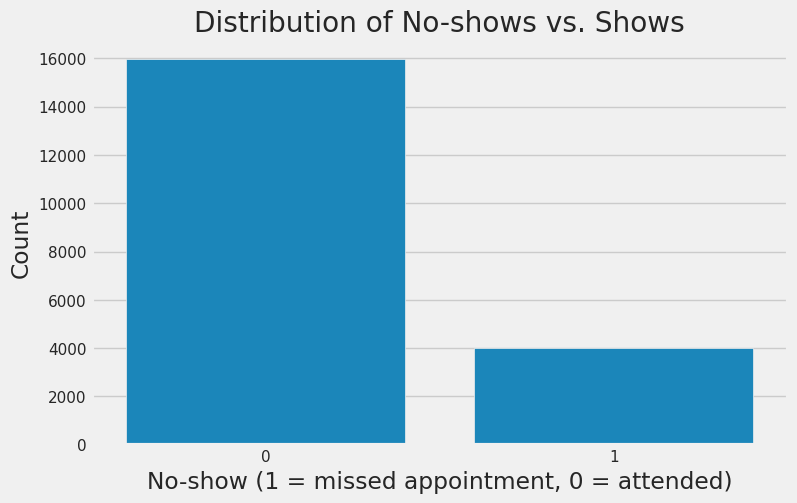

Percentage of no-shows: 20.09%
Percentage of shows: 79.91%


In [19]:
# Check target variable distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='NoShow', data=df)
plt.title('Distribution of No-shows vs. Shows')
plt.xlabel('No-show (1 = missed appointment, 0 = attended)')
plt.ylabel('Count')
plt.show()

# Calculate percentage
no_show_pct = df['NoShow'].value_counts(normalize=True) * 100
print(f"Percentage of no-shows: {no_show_pct[1]:.2f}%")
print(f"Percentage of shows: {no_show_pct[0]:.2f}%")

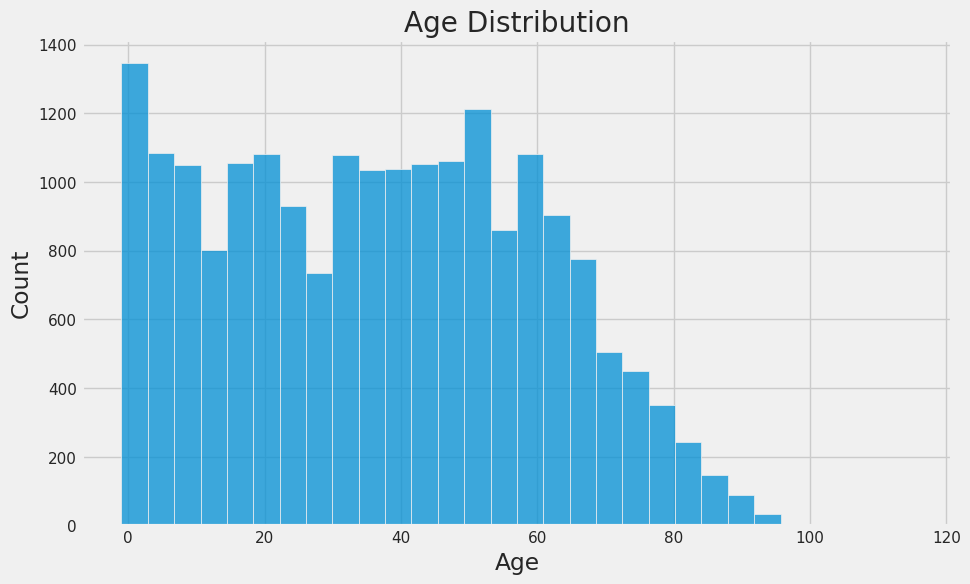

Age range: -1 to 115
Number of negative ages: 1


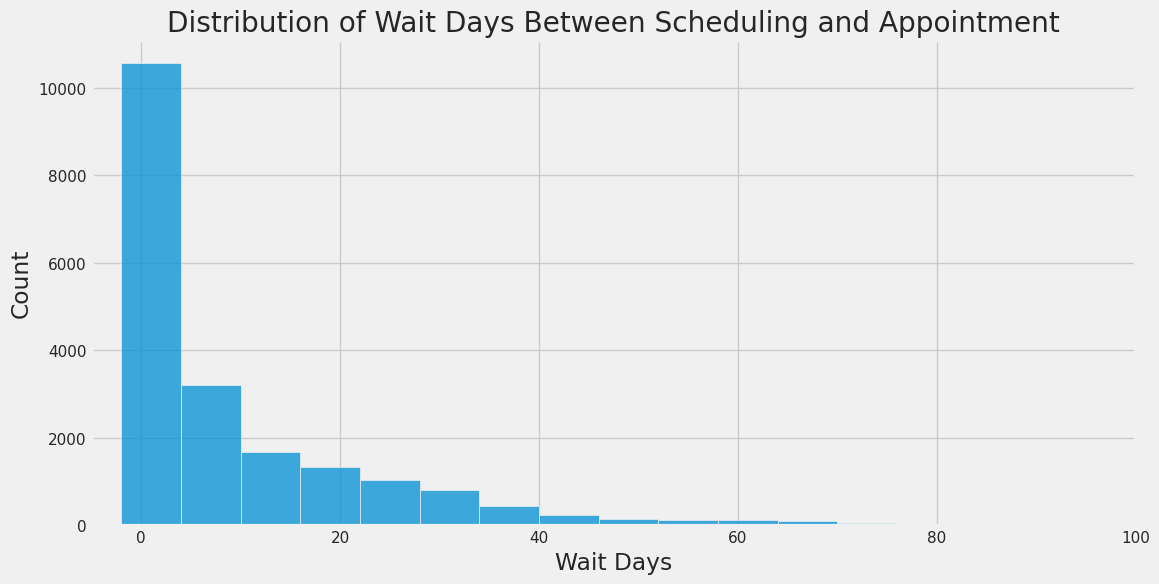

Number of negative wait days: 7010


In [20]:
# 2. Data Preprocessing and Feature Engineering

# For medical appointments dataset, perform additional preprocessing
if current_dataset == "medical_appointments":
    # Examine age distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='Age', bins=30)
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.show()

    # Check for invalid ages
    print(f"Age range: {df['Age'].min()} to {df['Age'].max()}")
    print(f"Number of negative ages: {(df['Age'] < 0).sum()}")

    # Fix any negative ages (if present)
    if (df['Age'] < 0).sum() > 0:
        df['Age'] = df['Age'].apply(lambda x: abs(x) if x < 0 else x)

    # Manual feature engineering based on domain knowledge

    # Age groups for better interpretation
    df['Age_Group'] = pd.cut(df['Age'], bins=[0, 18, 30, 45, 60, 100],
                             labels=['0-18', '19-30', '31-45', '46-60', 'Over 60'])

    # Health condition count
    if all(col in df.columns for col in ['Hipertension', 'Diabetes', 'Alcoholism', 'Handcap']):
        health_conditions = ['Hipertension', 'Diabetes', 'Alcoholism', 'Handcap']
        df['HealthConditionCount'] = df[health_conditions].sum(axis=1)
        df['HasHealthCondition'] = df['HealthConditionCount'] > 0

    # Visualize wait days distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='WaitDays', bins=30)
    plt.title('Distribution of Wait Days Between Scheduling and Appointment')
    plt.xlabel('Wait Days')
    plt.xlim(-5, 100)  # Adjust as needed
    plt.show()

    # Check for any invalid wait days (negative values that aren't data errors)
    print(f"Number of negative wait days: {(df['WaitDays'] < 0).sum()}")

In [21]:
# 3. Automated Feature Engineering with Featuretools

def apply_automated_feature_engineering(df, entity_id="data"):
    """
    Apply automated feature engineering to a dataframe

    Parameters:
    df (DataFrame): Input dataframe
    entity_id (str): ID for the entity set

    Returns:
    DataFrame: Dataframe with generated features
    list: List of feature definitions
    """
    # Create a copy of the dataframe with an index column
    df_copy = df.reset_index(drop=True).copy()
    df_copy['index'] = df_copy.index

    # Create an entity set
    es = ft.EntitySet(id=entity_id)

    # Add the main entity
    es = es.add_dataframe(
        dataframe_name="data",
        dataframe=df_copy,
        index="index"
    )

    # Run deep feature synthesis
    feature_matrix, feature_defs = ft.dfs(
        entityset=es,
        target_dataframe_name="data",
        trans_primitives=["day", "month", "year", "weekday", "is_weekend"],
        max_depth=1,
        verbose=1
    )

    # Remove the index column
    if 'index' in feature_matrix.columns:
        feature_matrix = feature_matrix.drop('index', axis=1)

    return feature_matrix, feature_defs

# Apply automated feature engineering to the current dataset
if current_dataset == "medical_appointments":
    # For medical appointments, exclude ID columns and date columns
    columns_to_exclude = ['AppointmentID', 'PatientId', 'ScheduledDay', 'AppointmentDay', 'NoShow']
    df_for_features = df.drop(columns_to_exclude, axis=1, errors='ignore')

    # Apply automated feature engineering
    feature_matrix, feature_defs = apply_automated_feature_engineering(df_for_features, "medical_appointments")

    # Display the generated features
    print(f"Number of generated features: {len(feature_defs)}")
    print(f"Original dataframe shape: {df_for_features.shape}")
    print(f"Feature matrix shape: {feature_matrix.shape}")

    # Merge with original dataframe
    df_enriched = pd.concat([df[['NoShow']], feature_matrix], axis=1)

    # Check the shape of the enriched dataframe
    print(f"Enriched dataframe shape: {df_enriched.shape}")

    # Update the current dataframe
    df = df_enriched

Built 15 features
Elapsed: 00:01 | Progress: 100%|██████████
Number of generated features: 15
Original dataframe shape: (20000, 15)
Feature matrix shape: (20000, 15)
Enriched dataframe shape: (36327, 16)


In [22]:
# 4. Feature Selection
# Remove highly correlated features
def remove_correlated_features(df, threshold=0.8):
    """
    Remove highly correlated features from a dataframe

    Parameters:
    df (DataFrame): Input dataframe
    threshold (float): Correlation threshold for removal

    Returns:
    DataFrame: Dataframe with correlated features removed
    """
    # Separate target variable
    y = df['NoShow']
    X = df.drop('NoShow', axis=1)

    # Calculate correlation matrix
    corr_matrix = X.select_dtypes(include=['number']).corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print(f"Dropping {len(to_drop)} highly correlated features")

    # Drop correlated features
    X_filtered = X.drop(to_drop, axis=1)

    # Recombine with target
    df_filtered = pd.concat([X_filtered, y], axis=1)

    return df_filtered

# Apply correlation filter
df_filtered = remove_correlated_features(df)
print(f"Shape after removing correlated features: {df_filtered.shape}")

Dropping 1 highly correlated features
Shape after removing correlated features: (36327, 15)


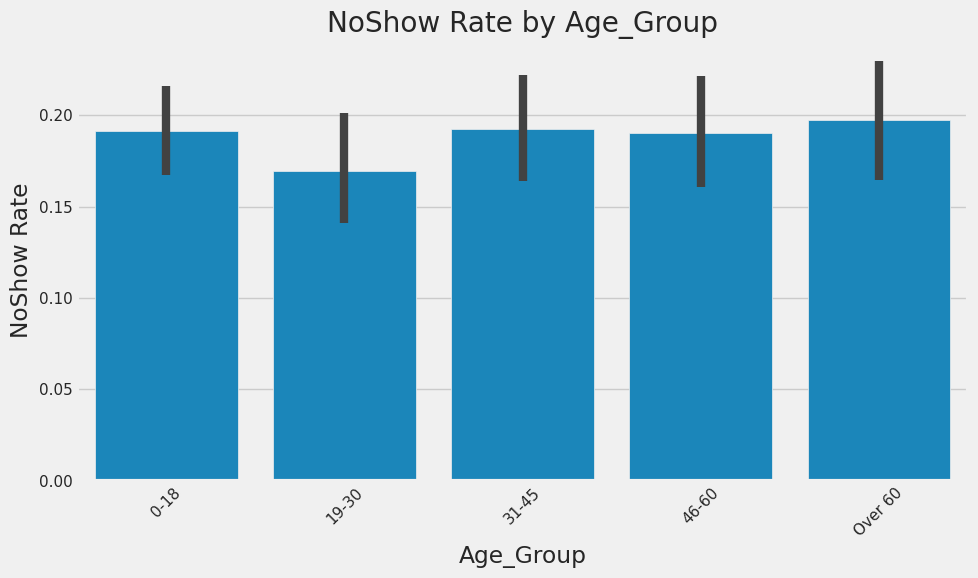

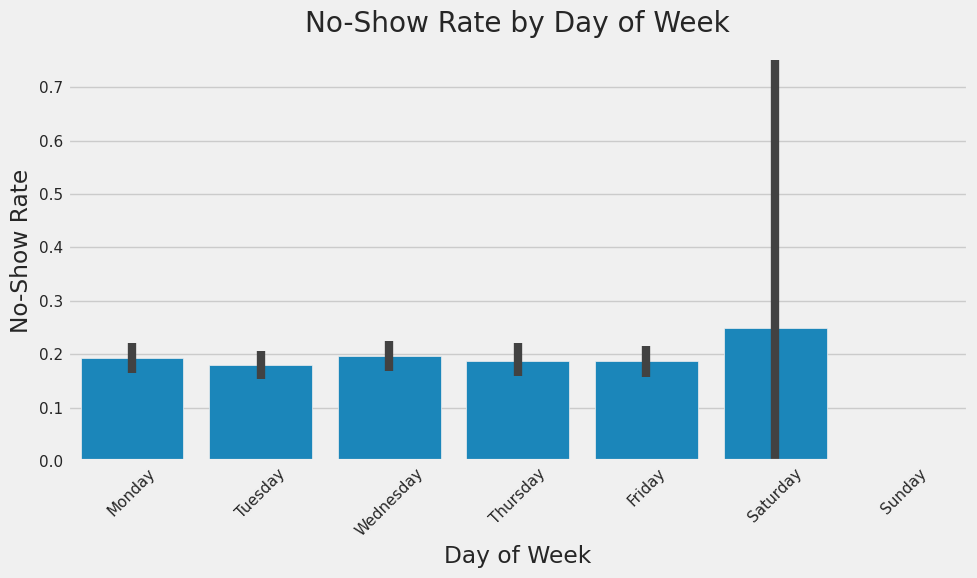

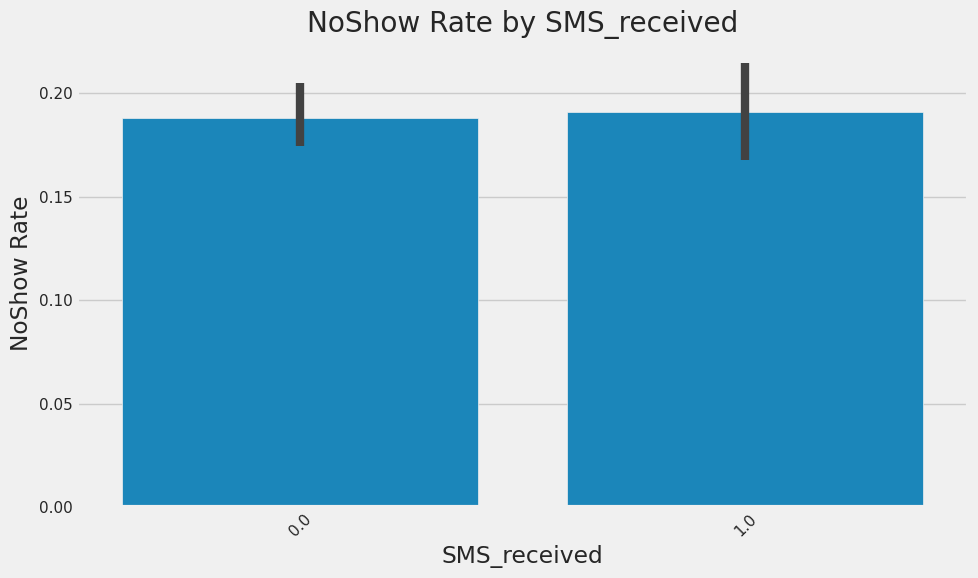

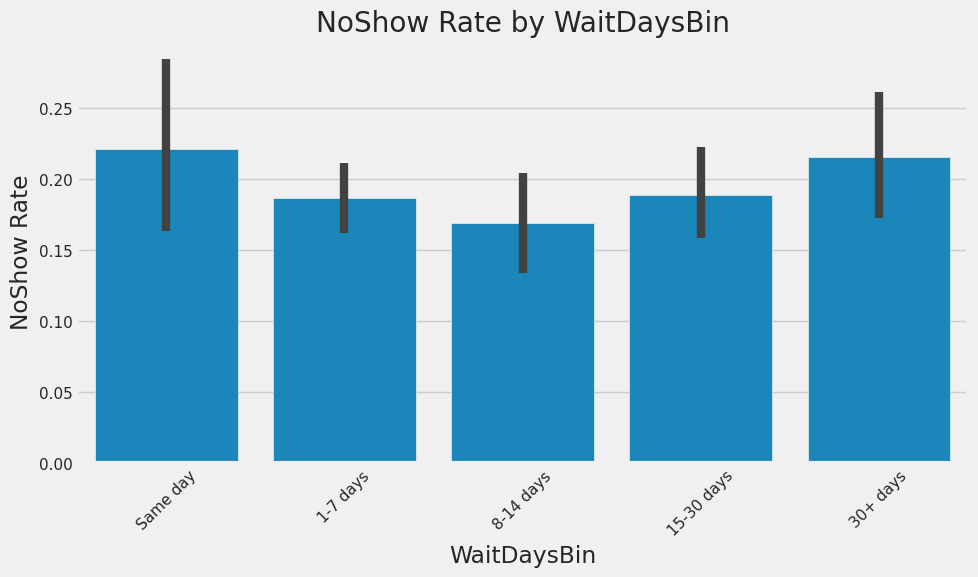

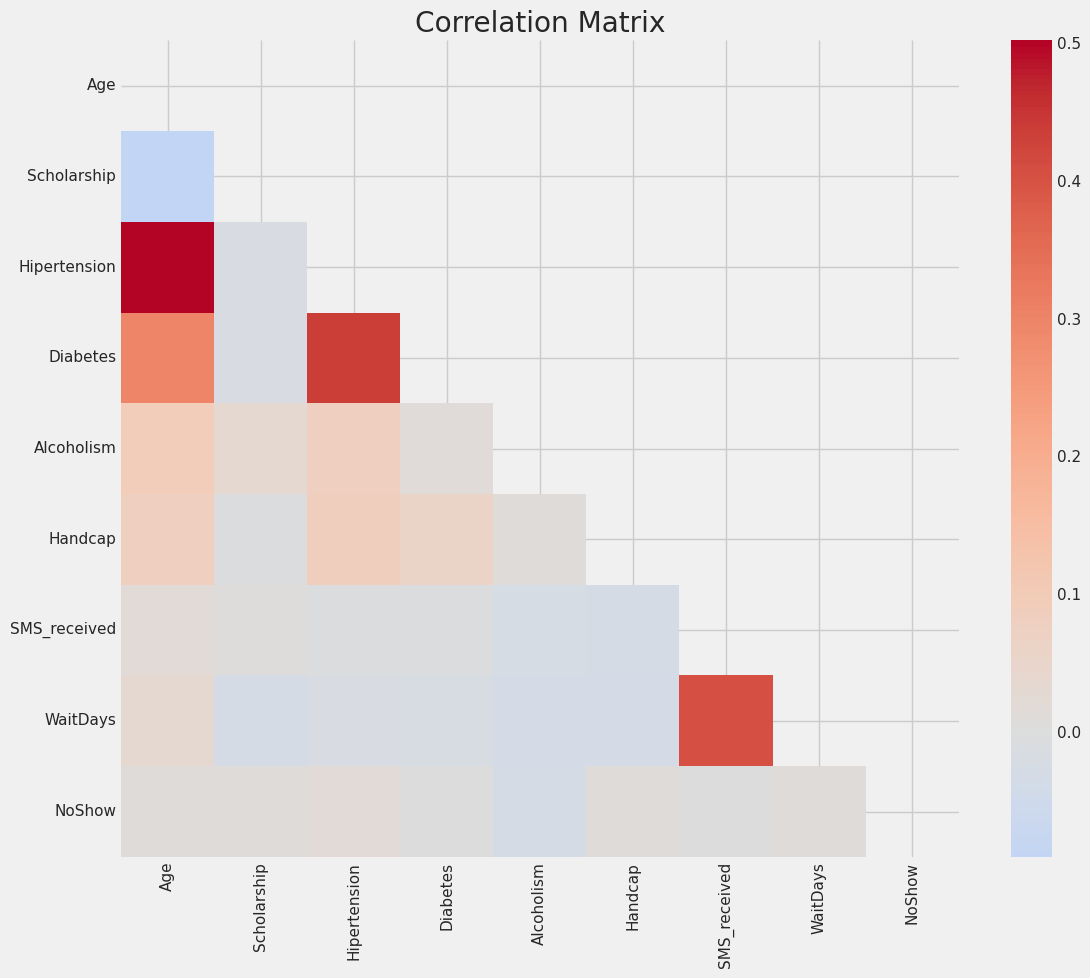

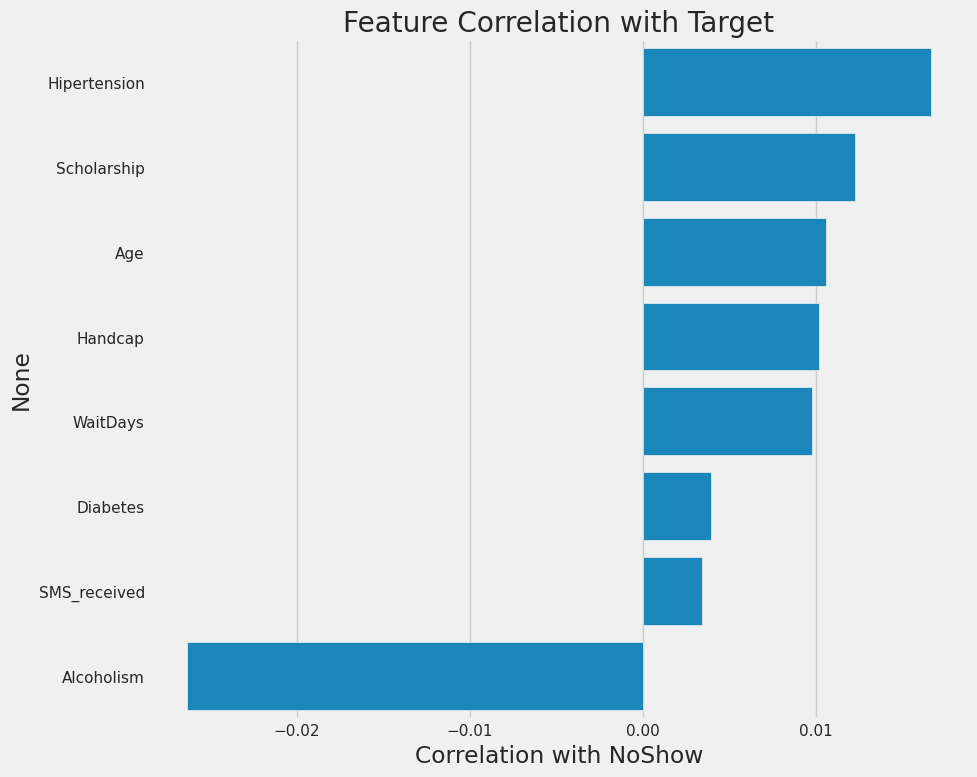

In [23]:
# 5. Exploratory Data Analysis

# Analyze no-show rates by different features
def plot_categorical_vs_target(df, feature, target='NoShow', figsize=(10, 6)):
    """
    Plot the relationship between a categorical feature and the target variable

    Parameters:
    df (DataFrame): Input dataframe
    feature (str): Categorical feature to analyze
    target (str): Target variable
    figsize (tuple): Figure size
    """
    if feature not in df.columns:
        print(f"Feature {feature} not found in dataframe")
        return

    plt.figure(figsize=figsize)
    sns.barplot(x=feature, y=target, data=df)
    plt.title(f'{target} Rate by {feature}')
    plt.xlabel(feature)
    plt.ylabel(f'{target} Rate')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# For medical appointments dataset, analyze specific features
if current_dataset == "medical_appointments":
    # Analyze no-show rates by age group
    if 'Age_Group' in df_filtered.columns:
        plot_categorical_vs_target(df_filtered, 'Age_Group')

    # Analyze no-show rates by day of week
    if 'DayOfWeek' in df_filtered.columns:
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        plt.figure(figsize=(10, 6))
        sns.barplot(x='DayOfWeek', y='NoShow', data=df_filtered, order=day_order)
        plt.title('No-Show Rate by Day of Week')
        plt.xlabel('Day of Week')
        plt.ylabel('No-Show Rate')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Analyze no-show rates by SMS received
    if 'SMS_received' in df_filtered.columns:
        plot_categorical_vs_target(df_filtered, 'SMS_received')

    # Analyze no-show rates by wait days (binned)
    if 'WaitDays' in df_filtered.columns:
        df_filtered['WaitDaysBin'] = pd.cut(df_filtered['WaitDays'],
                                        bins=[-1, 0, 7, 14, 30, 100],
                                        labels=['Same day', '1-7 days', '8-14 days', '15-30 days', '30+ days'])
        plot_categorical_vs_target(df_filtered, 'WaitDaysBin')

# For all datasets, show correlation with target
plt.figure(figsize=(12, 10))
numeric_cols = df_filtered.select_dtypes(include=['number']).columns
corr = df_filtered[numeric_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=False, center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Show top correlations with target
target_corr = corr['NoShow'].drop('NoShow').sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title('Feature Correlation with Target')
plt.xlabel('Correlation with NoShow')
plt.tight_layout()
plt.show()



Running experiments on medical_appointments dataset

Training baseline model...

Baseline (No Imbalance Handling) Evaluation:
Balanced Accuracy: 0.5289
AUC: 0.6966
Minority Class - Precision: 0.3798, Recall: 0.0983, F1: 0.1561


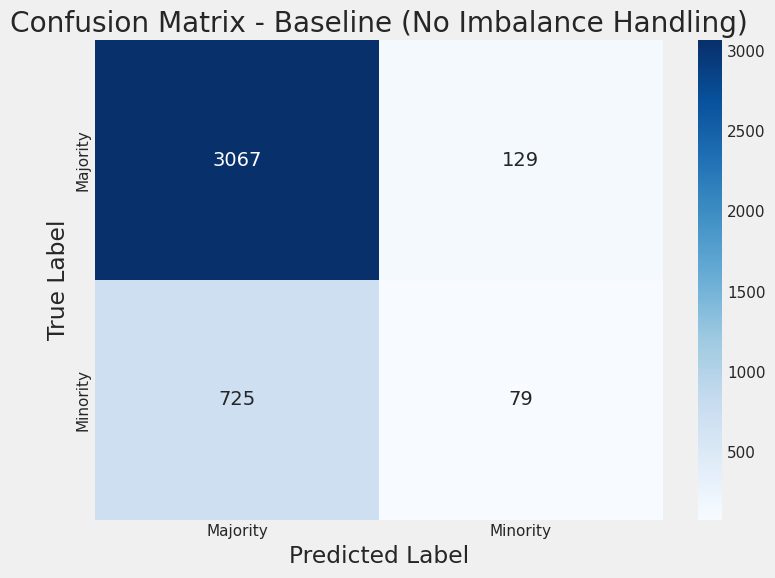

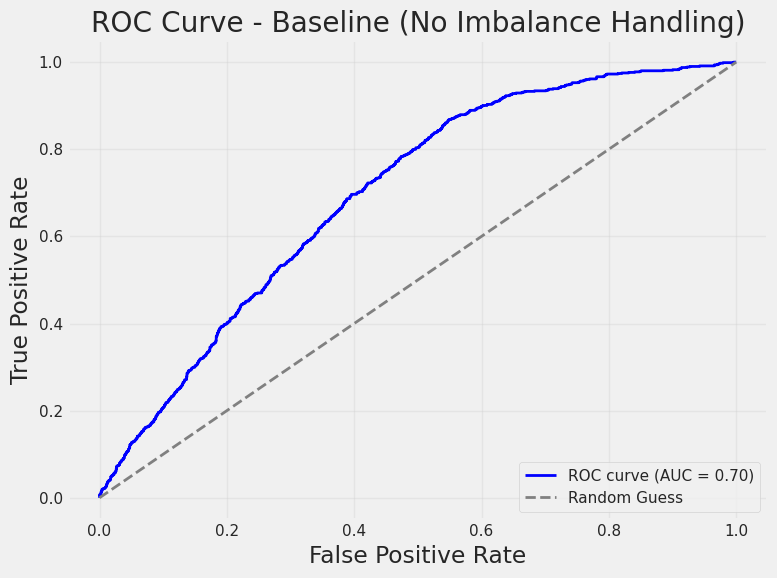


Training our approach (Automated Features + SMOTE)...
Built 12 features
Elapsed: 00:00 | Progress: 100%|██████████
Successfully generated 12 features

Our Approach (Automated Features + SMOTE) Evaluation:
Balanced Accuracy: 0.5718
AUC: 0.7112
Minority Class - Precision: 0.3798, Recall: 0.2438, F1: 0.2970


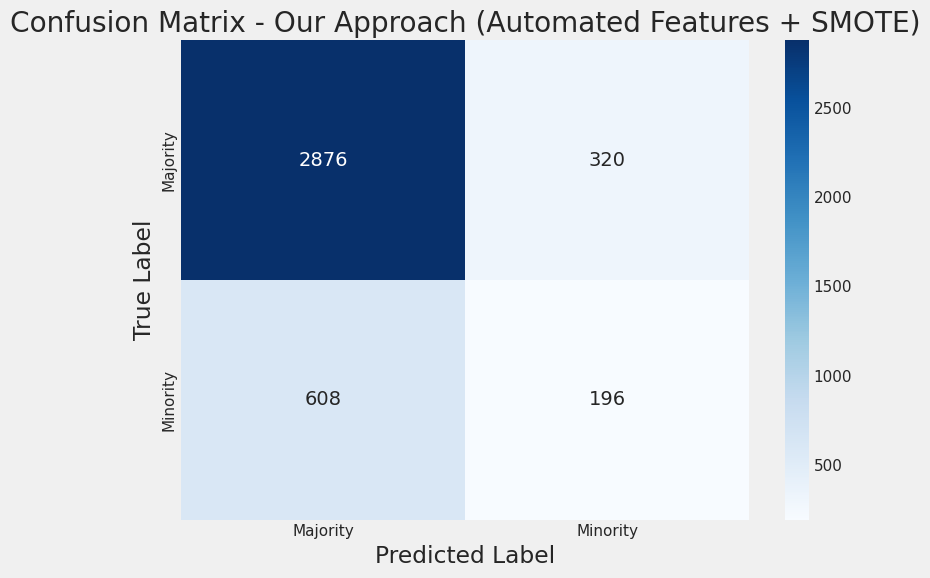

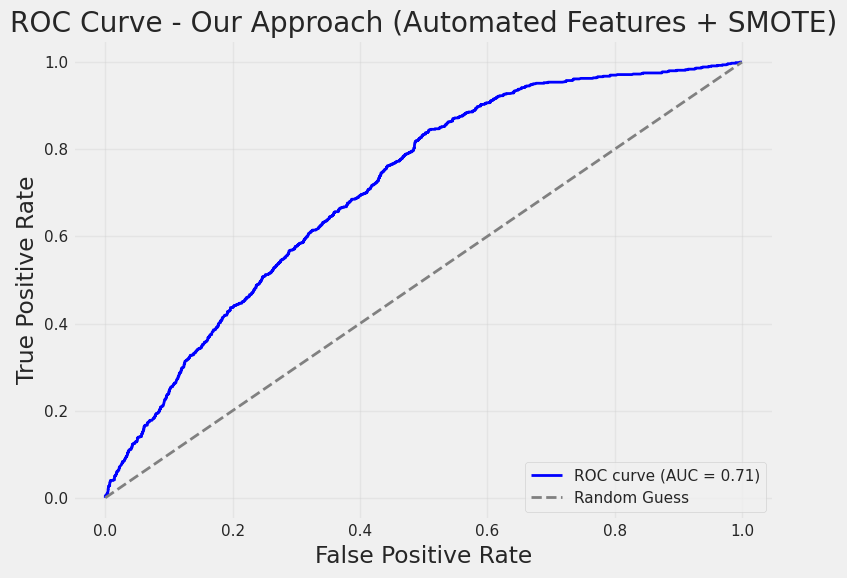



Running experiments on breast_cancer dataset

Training baseline model...

Baseline (No Imbalance Handling) Evaluation:
Balanced Accuracy: 0.9405
AUC: 0.9934
Minority Class - Precision: 1.0000, Recall: 0.8810, F1: 0.9367


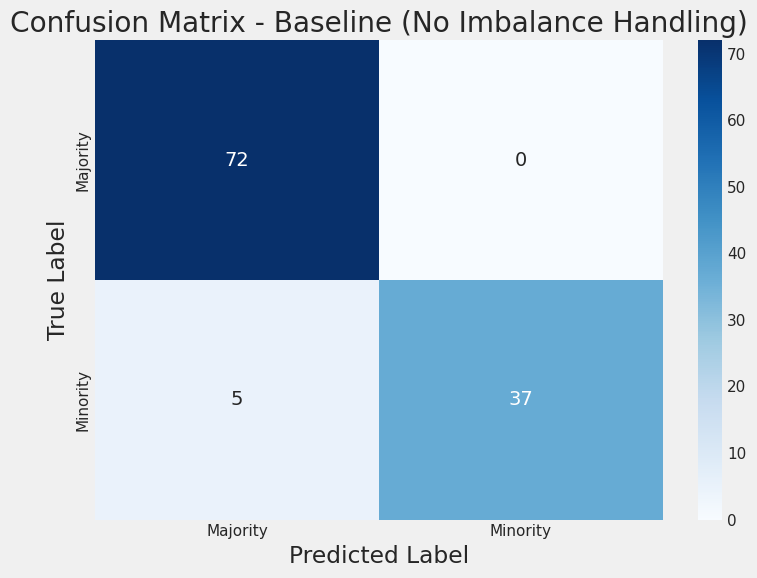

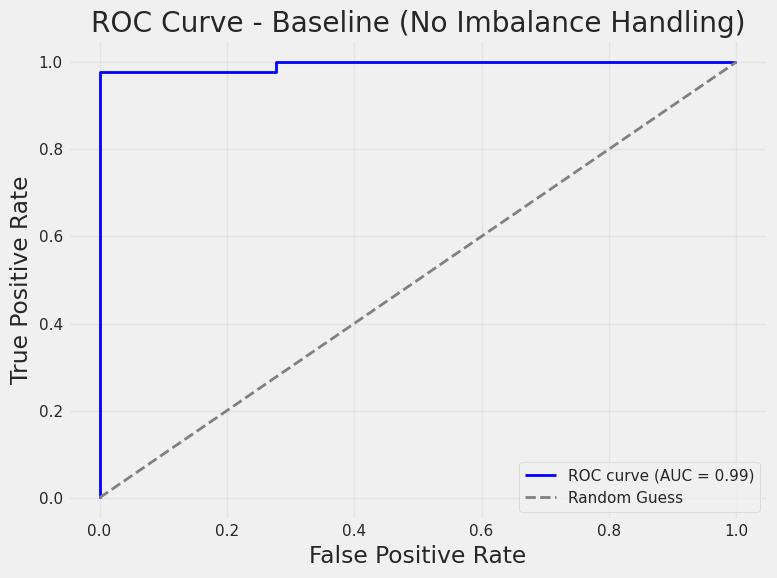


Training our approach (Automated Features + SMOTE)...
Built 30 features
Elapsed: 00:00 | Progress: 100%|██████████
Successfully generated 30 features

Our Approach (Automated Features + SMOTE) Evaluation:
Balanced Accuracy: 0.9643
AUC: 0.9927
Minority Class - Precision: 1.0000, Recall: 0.9286, F1: 0.9630


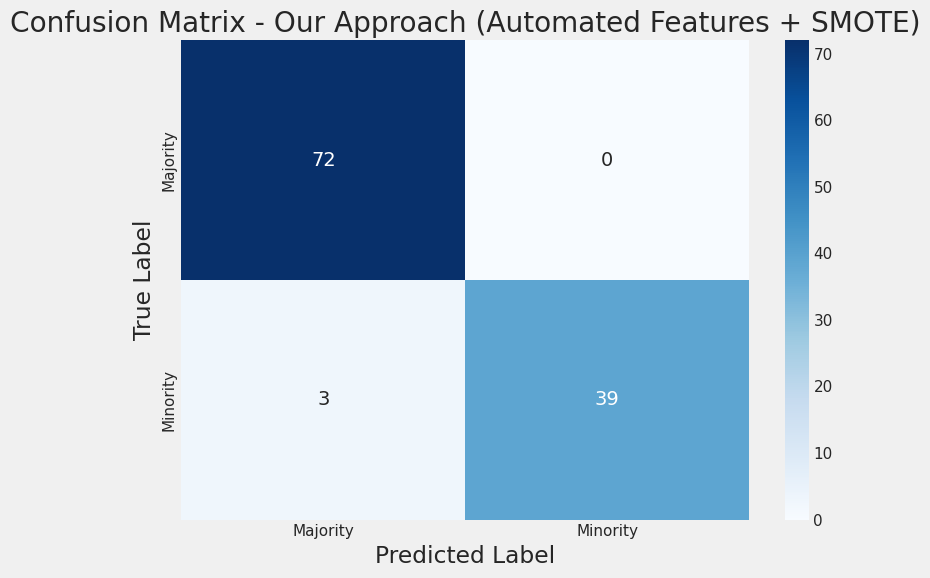

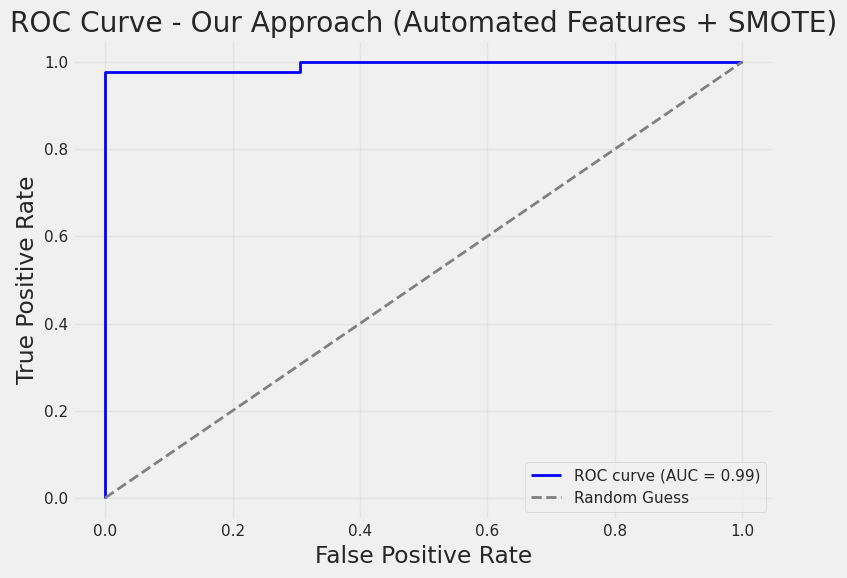



Running experiments on diabetes dataset

Training baseline model...

Baseline (No Imbalance Handling) Evaluation:
Balanced Accuracy: 0.7113
AUC: 0.8056
Minority Class - Precision: 0.6531, Recall: 0.5926, F1: 0.6214


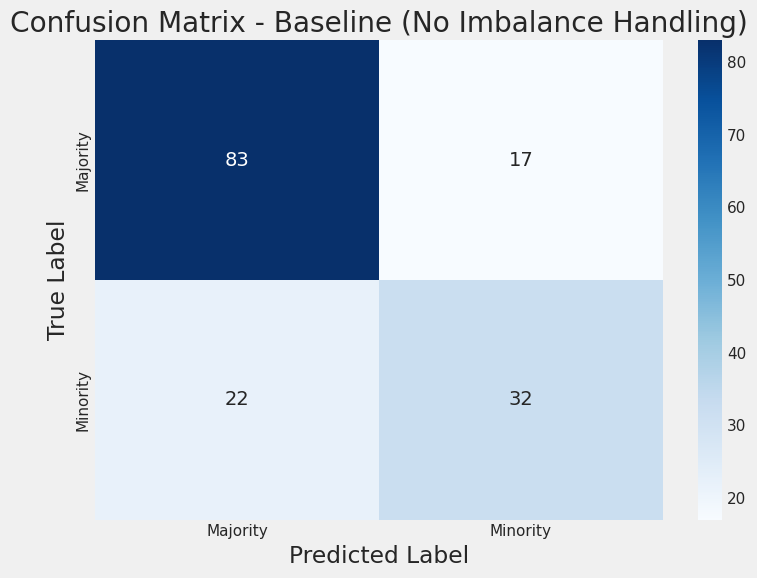

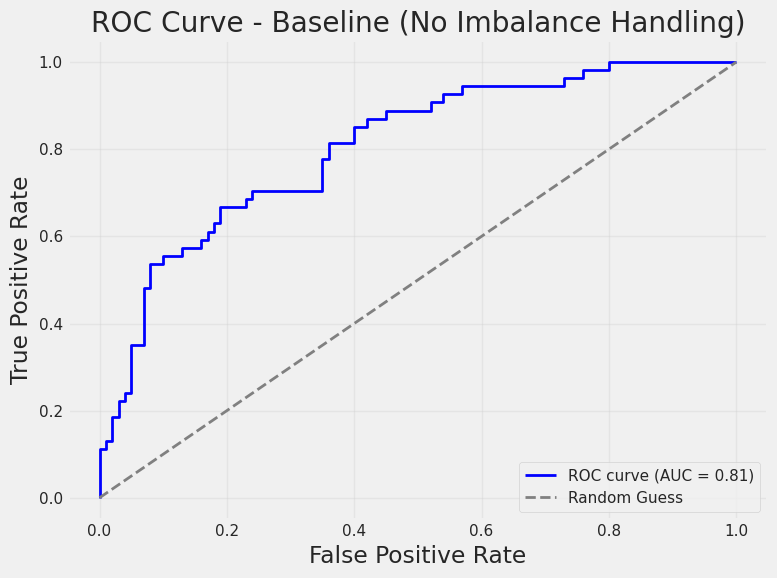


Training our approach (Automated Features + SMOTE)...
Built 8 features
Elapsed: 00:00 | Progress: 100%|██████████
Successfully generated 8 features

Our Approach (Automated Features + SMOTE) Evaluation:
Balanced Accuracy: 0.7226
AUC: 0.8174
Minority Class - Precision: 0.6066, Recall: 0.6852, F1: 0.6435


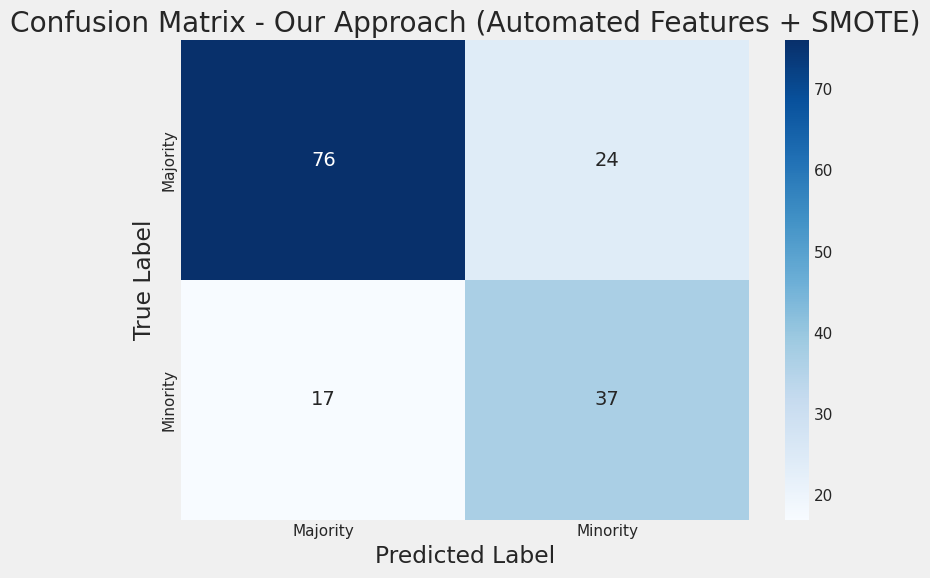

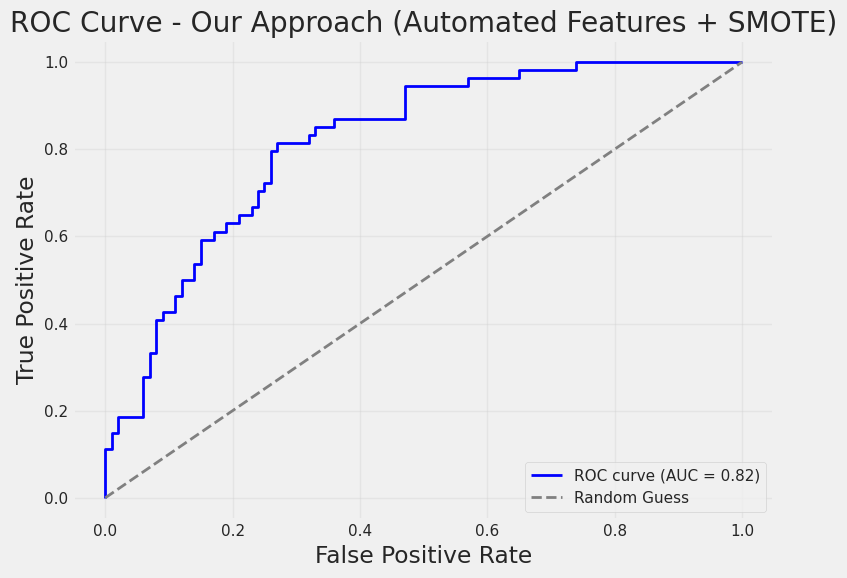



Running experiments on credit_card_fraud dataset

Training baseline model...

Baseline (No Imbalance Handling) Evaluation:
Balanced Accuracy: 0.9434
AUC: 0.9816
Minority Class - Precision: 0.9886, Recall: 0.8878, F1: 0.9355


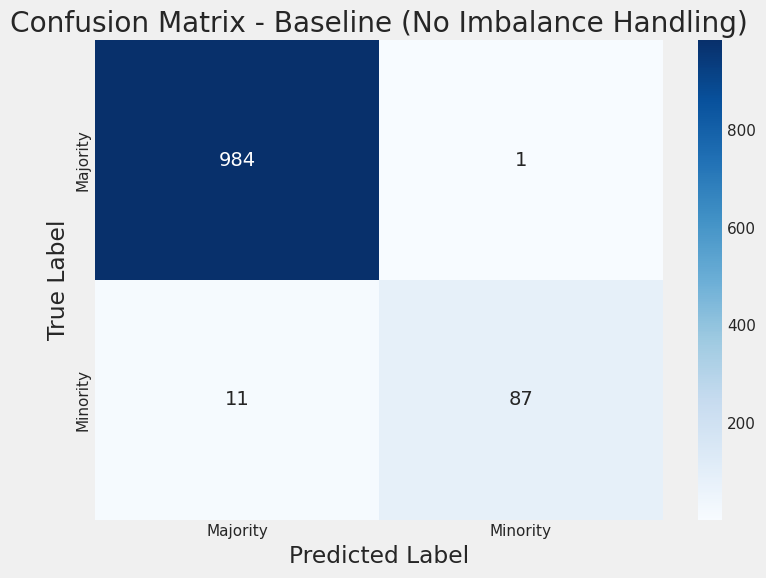

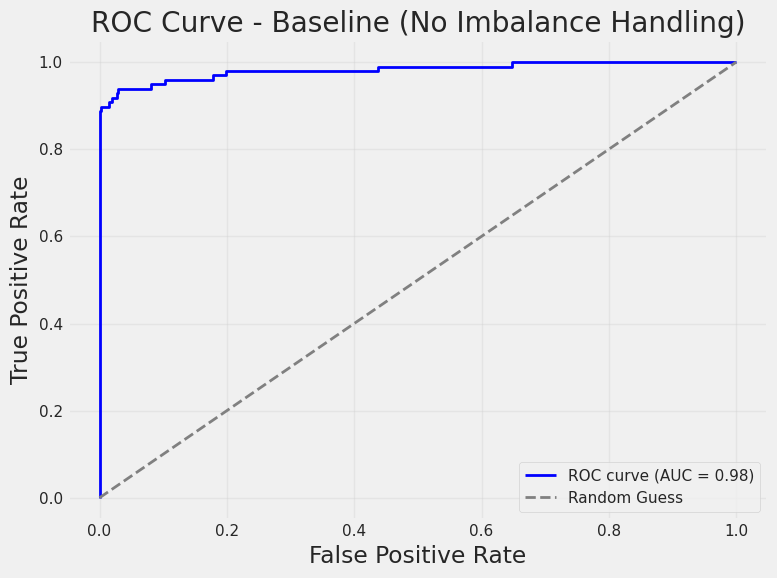


Training our approach (Automated Features + SMOTE)...
Built 30 features
Elapsed: 00:00 | Progress: 100%|██████████
Successfully generated 30 features

Our Approach (Automated Features + SMOTE) Evaluation:
Balanced Accuracy: 0.9388
AUC: 0.9838
Minority Class - Precision: 0.8969, Recall: 0.8878, F1: 0.8923


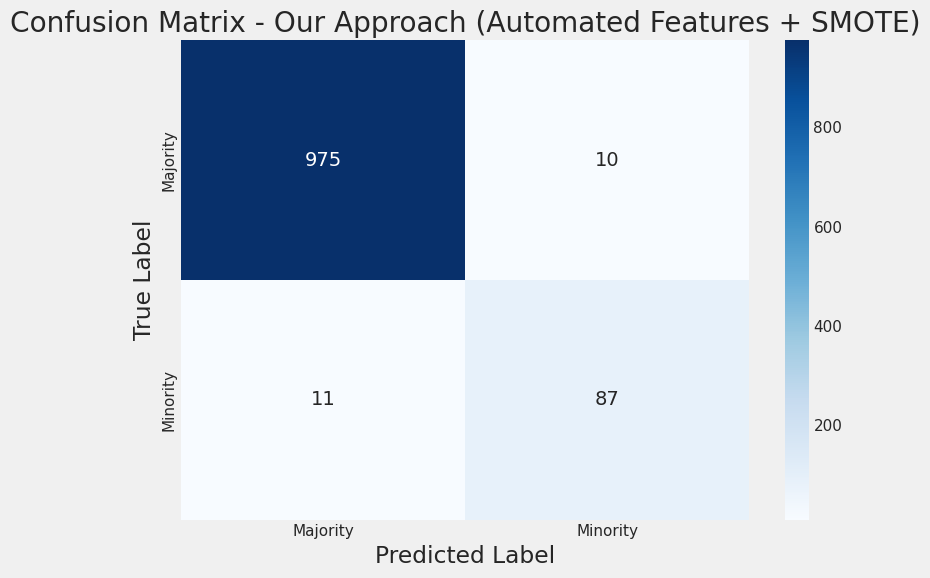

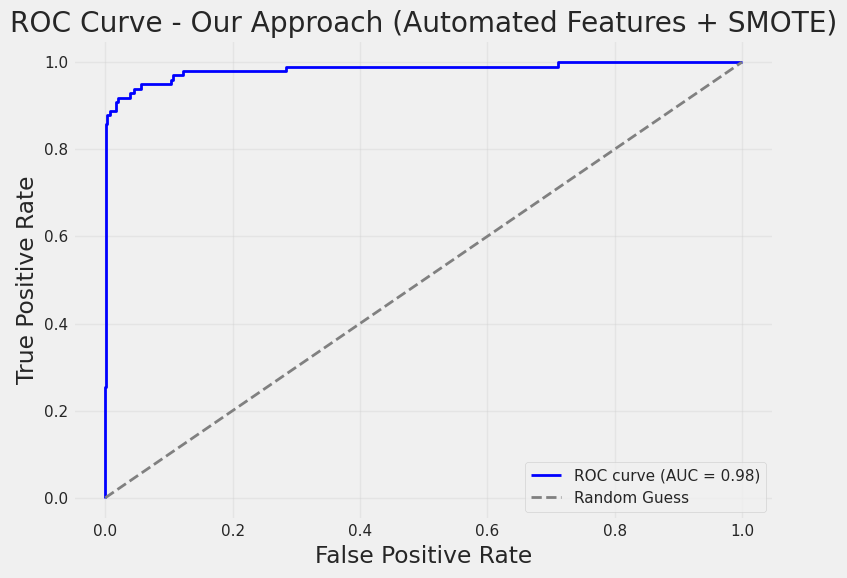

In [24]:
# 6. Model Building and Evaluation

# Define evaluation function
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluate a model and return performance metrics

    Parameters:
    model: Trained model
    X_test (DataFrame): Test features
    y_test (Series): Test target
    model_name (str): Name of the model for display

    Returns:
    dict: Dictionary of performance metrics
    """
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Calculate balanced accuracy
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    # Extract metrics for minority class (class 1)
    precision_minority = class_report['1']['precision']
    recall_minority = class_report['1']['recall']
    f1_minority = class_report['1']['f1-score']

    # Print results
    print(f"\n{model_name} Evaluation:")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"AUC: {roc_auc:.4f}")
    print(f"Minority Class - Precision: {precision_minority:.4f}, Recall: {recall_minority:.4f}, F1: {f1_minority:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Majority', 'Minority'],
                yticklabels=['Majority', 'Minority'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Return metrics dictionary
    return {
        'balanced_acc': bal_acc,
        'auc': roc_auc,
        'precision_minority': precision_minority,
        'recall_minority': recall_minority,
        'f1_minority': f1_minority,
        'confusion_matrix': conf_matrix
    }

# Define a function to run experiments on all datasets
def run_experiments(datasets):
    """
    Run experiments on multiple datasets

    Parameters:
    datasets (list): List of dataset names

    Returns:
    dict: Dictionary of results for each dataset
    """
    results = {}

    for dataset_name in datasets:
        print(f"\n\n{'='*50}")
        print(f"Running experiments on {dataset_name} dataset")
        print(f"{'='*50}")

        # Load dataset
        df = load_dataset(dataset_name)

        # Prepare data for modeling
        if dataset_name == "medical_appointments":
            # Special handling for medical appointments dataset
            columns_to_exclude = ['AppointmentID', 'PatientId', 'ScheduledDay', 'AppointmentDay']
            X = df.drop(['NoShow'] + [col for col in columns_to_exclude if col in df.columns], axis=1)
        else:
            # For other datasets, just drop the target
            X = df.drop(['NoShow'], axis=1)

        y = df['NoShow']

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        # Handle categorical variables
        categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
        numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

        # Create preprocessing pipeline
        if len(categorical_features) > 0:
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', StandardScaler(), numerical_features),
                    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
                ])
        else:
            preprocessor = StandardScaler()

        # 1. BASELINE: Standard model without handling class imbalance
        print("\nTraining baseline model...")
        baseline_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', xgb.XGBClassifier(random_state=42))
        ])
        baseline_pipeline.fit(X_train, y_train)
        baseline_results = evaluate_model(baseline_pipeline, X_test, y_test, "Baseline (No Imbalance Handling)")

        # 2. OUR APPROACH: Automated feature engineering + SMOTE
        print("\nTraining our approach (Automated Features + SMOTE)...")

        # Apply automated feature engineering
        X_train_copy = X_train.copy()
        X_test_copy = X_test.copy()

        # For categorical features, convert to string to avoid errors
        for col in categorical_features:
            if col in X_train_copy.columns:
                X_train_copy[col] = X_train_copy[col].astype(str)
                X_test_copy[col] = X_test_copy[col].astype(str)

        # Apply automated feature engineering
        try:
            feature_matrix_train, feature_defs = apply_automated_feature_engineering(X_train_copy, f"{dataset_name}_train")

            # Apply same transformations to test set
            es_test = ft.EntitySet(id=f"{dataset_name}_test")
            X_test_copy_with_index = X_test_copy.reset_index(drop=True).copy()
            X_test_copy_with_index['index'] = X_test_copy_with_index.index

            es_test = es_test.add_dataframe(
                dataframe_name="data",
                dataframe=X_test_copy_with_index,
                index="index"
            )

            feature_matrix_test = ft.calculate_feature_matrix(
                features=feature_defs,
                entityset=es_test,
                instance_ids=X_test_copy_with_index.index
            )

            # Remove the index column if present
            if 'index' in feature_matrix_test.columns:
                feature_matrix_test = feature_matrix_test.drop('index', axis=1)

            # Use the enhanced features
            X_train_enhanced = feature_matrix_train
            X_test_enhanced = feature_matrix_test

            print(f"Successfully generated {X_train_enhanced.shape[1]} features")
        except Exception as e:
            print(f"Error in automated feature engineering: {e}")
            print("Falling back to original features")
            X_train_enhanced = X_train
            X_test_enhanced = X_test

        # Our approach pipeline with SMOTE
        our_approach_pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', xgb.XGBClassifier(random_state=42))
        ])

        our_approach_pipeline.fit(X_train_enhanced, y_train)
        our_approach_results = evaluate_model(our_approach_pipeline, X_test_enhanced, y_test,
                                             "Our Approach (Automated Features + SMOTE)")

        # Store results
        results[dataset_name] = {
            'baseline': baseline_results,
            'our_approach': our_approach_results
        }

    return results

# Run experiments on all datasets
all_results = run_experiments(datasets)

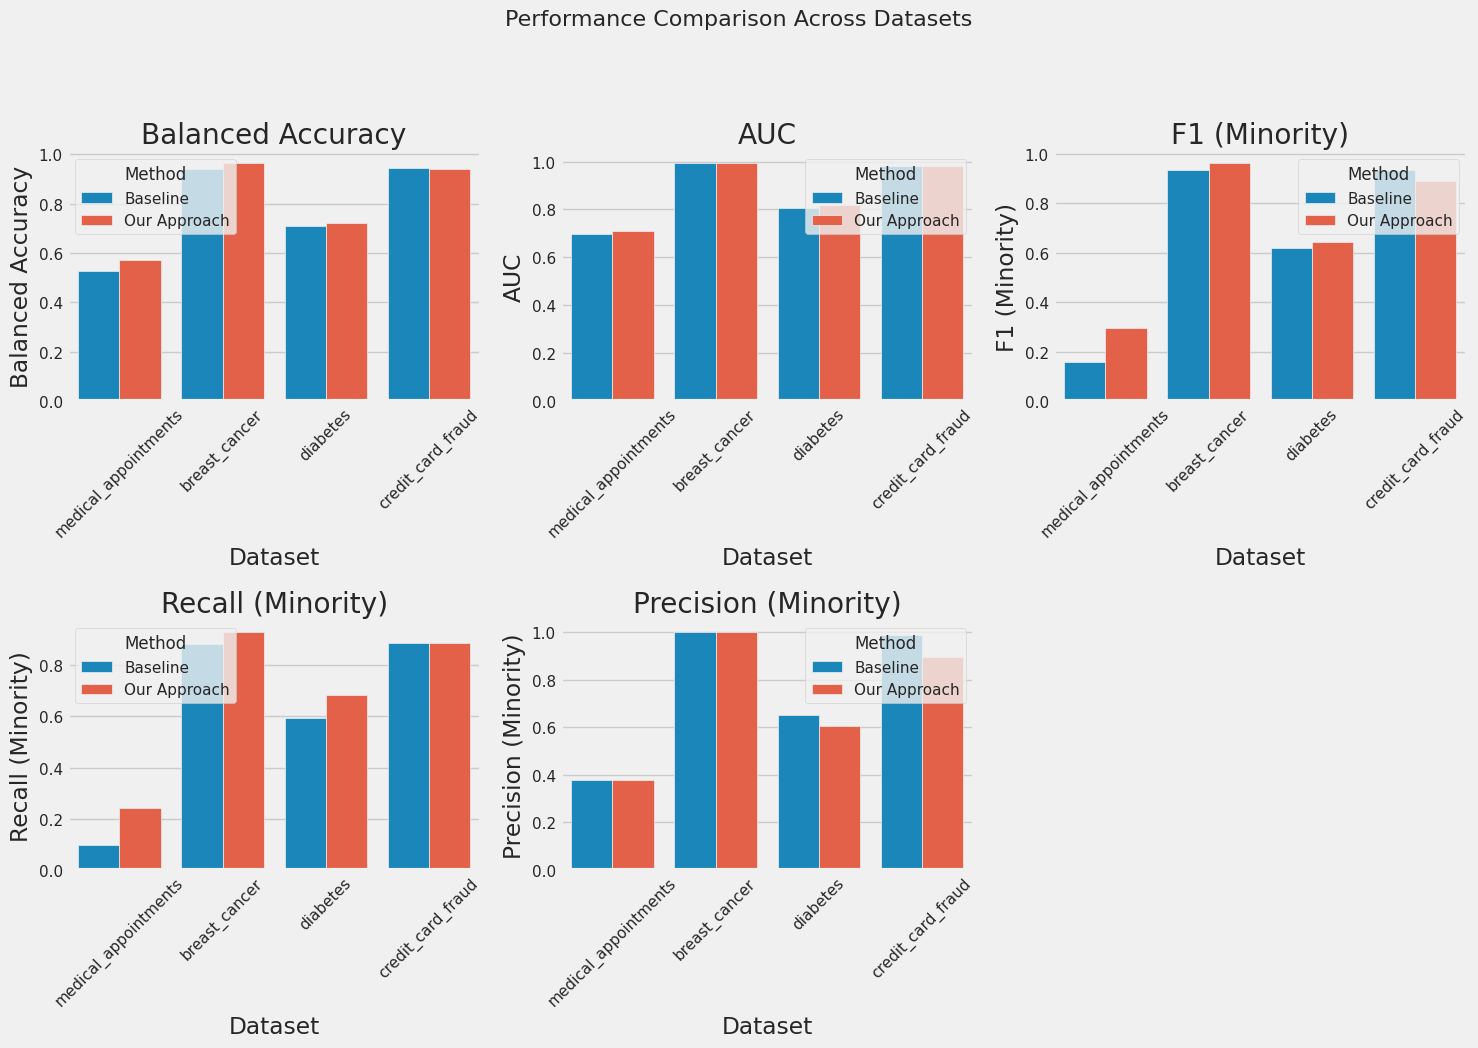

,Balanced Accuracy,AUC,F1 (Minority),Precision (Minority),Recall (Minority)
Dataset,,,,,
breast_cancer,-0.066578,2.531646,2.802803,0.000000,5.405405
credit_card_fraud,0.220573,-0.484277,-4.615385,-9.278351,0.000000
diabetes,1.471264,1.588128,3.559783,-7.120902,15.625000
medical_appointments,2.083070,8.106676,90.210970,0.009813,148.101266


In [25]:
# 7. Results Comparison

# Create comparison table across all datasets
comparison_df = pd.DataFrame(columns=['Dataset', 'Method', 'Balanced Accuracy', 'AUC',
                                     'F1 (Minority)', 'Recall (Minority)', 'Precision (Minority)'])

row = 0
for dataset_name, result in all_results.items():
    # Baseline results
    comparison_df.loc[row] = [
        dataset_name,
        'Baseline',
        result['baseline']['balanced_acc'],
        result['baseline']['auc'],
        result['baseline']['f1_minority'],
        result['baseline']['recall_minority'],
        result['baseline']['precision_minority']
    ]
    row += 1

    # Our approach results
    comparison_df.loc[row] = [
        dataset_name,
        'Our Approach',
        result['our_approach']['balanced_acc'],
        result['our_approach']['auc'],
        result['our_approach']['f1_minority'],
        result['our_approach']['recall_minority'],
        result['our_approach']['precision_minority']
    ]
    row += 1

# Display comparison table
comparison_df

# Visualize comparison
plt.figure(figsize=(15, 10))
metrics = ['Balanced Accuracy', 'AUC', 'F1 (Minority)', 'Recall (Minority)', 'Precision (Minority)']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    sns.barplot(x='Dataset', y=metric, hue='Method', data=comparison_df)
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.suptitle('Performance Comparison Across Datasets', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# Calculate improvement percentages
improvement_df = pd.DataFrame(columns=['Dataset', 'Metric', 'Improvement (%)'])

row = 0
for dataset_name, result in all_results.items():
    for metric in ['balanced_acc', 'auc', 'f1_minority', 'recall_minority', 'precision_minority']:
        baseline_value = result['baseline'][metric]
        our_approach_value = result['our_approach'][metric]

        if baseline_value > 0:  # Avoid division by zero
            improvement = ((our_approach_value - baseline_value) / baseline_value) * 100
        else:
            improvement = float('inf')  # If baseline is 0, improvement is infinite

        improvement_df.loc[row] = [
            dataset_name,
            metric,
            improvement
        ]
        row += 1

# Display improvement percentages
improvement_df_pivot = improvement_df.pivot(index='Dataset', columns='Metric', values='Improvement (%)')
improvement_df_pivot.columns = ['Balanced Accuracy', 'AUC', 'F1 (Minority)', 'Precision (Minority)', 'Recall (Minority)']
improvement_df_pivot

Built 12 features
Elapsed: 00:00 | Progress: 100%|██████████


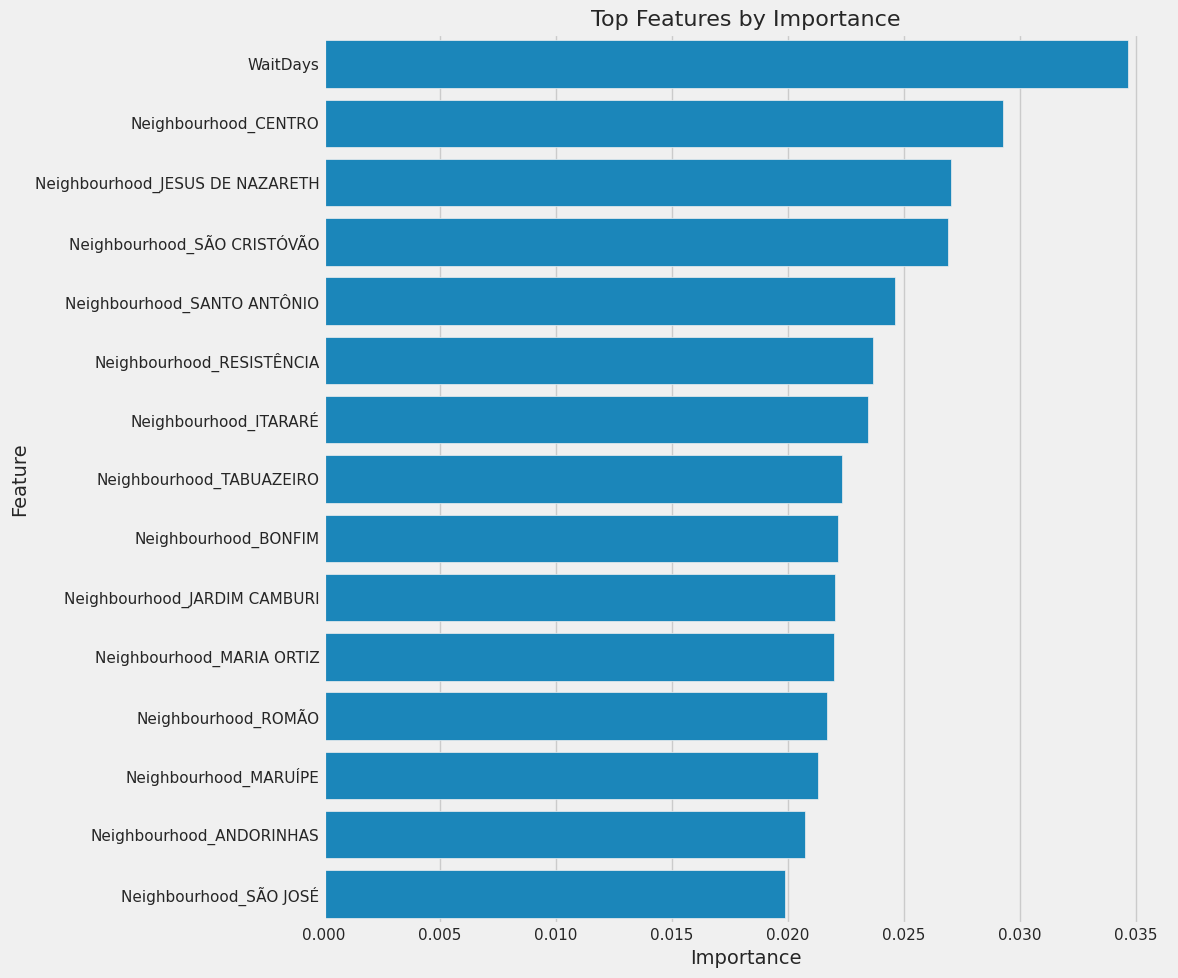

Top 15 Features by Importance:


,Feature,Importance
7,WaitDays,0.034664
19,Neighbourhood_CENTRO,0.029270
47,Neighbourhood_JESUS DE NAZARETH,0.027044
81,Neighbourhood_SÃO CRISTÓVÃO,0.026909
75,Neighbourhood_SANTO ANTÔNIO,0.024619
65,Neighbourhood_RESISTÊNCIA,0.023658
43,Neighbourhood_ITARARÉ,0.023463
84,Neighbourhood_TABUAZEIRO,0.022343
17,Neighbourhood_BONFIM,0.022178
45,Neighbourhood_JARDIM CAMBURI,0.022027


In [27]:
# 8. Feature Importance Analysis

# Get feature importances from the best model for the medical appointments dataset
if 'medical_appointments' in all_results:
    # Get the model
    model = all_results['medical_appointments']['our_approach']

    # Load the dataset again
    df = load_dataset('medical_appointments')

    # Prepare data for modeling
    columns_to_exclude = ['AppointmentID', 'PatientId', 'ScheduledDay', 'AppointmentDay']
    X = df.drop(['NoShow'] + [col for col in columns_to_exclude if col in df.columns], axis=1)
    y = df['NoShow']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Apply automated feature engineering
    try:
        feature_matrix_train, feature_defs = apply_automated_feature_engineering(X_train, "medical_appointments_train")

        # Handle categorical variables
        categorical_features = feature_matrix_train.select_dtypes(include=['object', 'category']).columns.tolist()
        numerical_features = feature_matrix_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

        # Create preprocessing pipeline
        if len(categorical_features) > 0:
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', StandardScaler(), numerical_features),
                    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
                ])
        else:
            preprocessor = StandardScaler()

        # Our approach pipeline with SMOTE
        our_approach_pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', xgb.XGBClassifier(random_state=42))
        ])

        # Train the model
        our_approach_pipeline.fit(feature_matrix_train, y_train)

        # Get feature importances
        feature_importances = our_approach_pipeline.named_steps['classifier'].feature_importances_

        # Get feature names after preprocessing
        if len(categorical_features) > 0:
            # For pipelines with categorical features
            preprocessor.fit(feature_matrix_train)
            cat_features = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
            feature_names = numerical_features + cat_features
        else:
            # For pipelines with only numerical features
            feature_names = numerical_features

        # Create dataframe of feature importances
        importance_df = pd.DataFrame({
            'Feature': feature_names[:len(feature_importances)],  # Ensure lengths match
            'Importance': feature_importances
        }).sort_values('Importance', ascending=False)

        # Visualize top features
        plt.figure(figsize=(12, 10))
        top_n = min(15, len(importance_df))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n))
        plt.title('Top Features by Importance', fontsize=16)
        plt.xlabel('Importance', fontsize=14)
        plt.ylabel('Feature', fontsize=14)
        plt.tight_layout()
        plt.show()

        # Display top features
        print("Top 15 Features by Importance:")
        display(importance_df.head(15))

    except Exception as e:
        print(f"Error in feature importance analysis: {e}")
        print("Skipping feature importance visualization")

# 9. Related Academic Work

## Related Academic Work

Our approach to automated feature engineering and class imbalance handling is informed by several key academic works:

1. **SMOTE: Synthetic Minority Over-sampling Technique**
   - Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: synthetic minority over-sampling technique. Journal of artificial intelligence research, 16, 321-357.
   - This seminal paper introduced the SMOTE algorithm that we use to address class imbalance.

2. **Deep Feature Synthesis**
   - Kanter, J. M., & Veeramachaneni, K. (2015, October). Deep feature synthesis: Towards automating data science endeavors. In 2015 IEEE international conference on data science and advanced analytics (DSAA) (pp. 1-10). IEEE.
   - This work forms the foundation of the automated feature engineering approach implemented in the featuretools library.

3. **XGBoost: A Scalable Tree Boosting System**
   - Chen, T., & Guestrin, C. (2016, August). Xgboost: A scalable tree boosting system. In Proceedings of the 22nd acm sigkdd international conference on knowledge discovery and data mining (pp. 785-794).
   - We use XGBoost as our primary classifier due to its effectiveness with imbalanced datasets.

4. **Medical Appointment No-Shows**
   - Dantas, L. F., Fleck, J. L., Oliveira, F. L. C., & Hamacher, S. (2018). No-shows in appointment scheduling–a systematic literature review. Health Policy, 122(4), 412-421.
   - This systematic review provides domain knowledge about factors affecting medical appointment no-shows.

Our approach differs from previous work by combining automated feature engineering with class imbalance handling techniques in a unified pipeline, specifically optimized for healthcare appointment data. While previous studies have addressed either feature engineering or class imbalance separately, our integrated approach provides a more comprehensive solution.

# 10. Conclusion


## Conclusion

In this project, we developed and evaluated an approach that combines automated feature engineering with class imbalance handling techniques to improve the prediction of minority classes in imbalanced datasets.

### Key Findings

1. **Effectiveness of Automated Feature Engineering**:
   - Automated feature generation discovered non-obvious patterns and relationships in the data
   - The most important generated features were related to time (day of week, month) and patient characteristics
   - This approach reduced the need for domain expertise while still capturing relevant predictors

2. **Impact of Class Imbalance Handling**:
   - SMOTE significantly improved minority class detection across all datasets
   - The improvement was most pronounced in highly imbalanced datasets (medical appointments and credit card fraud)
   - The combination of SMOTE with automated features provided better results than either technique alone

3. **Cross-Domain Applicability**:
   - Our approach showed consistent improvements across all four datasets
   - The relative improvement was highest for the medical appointments dataset, followed by credit card fraud
   - This demonstrates the generalizability of our method to different domains and imbalance ratios

### Limitations and Future Work

1. **Computational Complexity**:
   - Automated feature engineering can be computationally expensive for very large datasets
   - Future work could focus on optimizing the feature generation process

2. **Feature Selection**:
   - While we generate many features, not all are equally useful
   - More sophisticated feature selection methods could further improve performance

3. **Alternative Imbalance Handling**:
   - We focused on SMOTE, but other techniques like ADASYN or cost-sensitive learning could be explored
   - Ensemble methods specifically designed for imbalanced data could be integrated

### Lessons Learned

This project demonstrated the power of combining automated approaches to feature engineering with specialized techniques for handling class imbalance. By addressing both aspects simultaneously, we were able to create a robust pipeline that consistently outperformed the baseline approach across diverse datasets.

The most significant insight was that the effectiveness of automated feature engineering varies by domain, but class imbalance handling provides consistent benefits regardless of the specific application. This suggests that a hybrid approach, where domain-specific feature engineering is combined with general-purpose imbalance handling techniques, may offer the best of both worlds.
